# Image Generation using Variational AutoEncoders

The goal of Autoencoders was to generate latent vectors which are easily decodable back to the original image. But this can cause the latent space to become disjoint and non-continous.

Variational Autoencoders were introduced to remedy this. Variational Autoencoders are trained to learn the probability distribution that models the input data. In varional autoencoders, the inputs are mapped to a probability distribuion over latent vectors. Typically, this probability distribution is set to standard normal distribution. So, there are two targets in VAEs: one to minimize the reconstruction loss and two to minimize the KL divergence between the Probilitistic encoder and standard normal distribution.


!["Variational Autoencoder Architecture"](https://blog.bayeslabs.co/assets/img/vae-gaussian.png)

<p align = "center">
Fig.1 - Variational Autoencoder Architecture
(<a href=https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae">
source
</a>)
</p>

In [15]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
#from dataloader_fossilnet import FossilNET

# Data downloading

In [16]:
import os
import os.path

from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_and_extract_archive, verify_str_arg


class FossilNET(ImageFolder):
    """`FossilNET <https://github.com/softwareunderground/fossilnet>`_ Dataset.
    Modified from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
    Args:
        root (string): Root directory of dataset where ``EMNIST/processed/training.pt``
            and  ``EMNIST/processed/test.pt`` exist.
        split (string): The dataset has 3 different splits: ``train``, ``val``,
            ``test``. This argument specifies
            which one to use.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    url = 'https://swung-data.s3.amazonaws.com/fossilnet/fossilnet-png-224px.zip'
    folder = 'fossilnet-png-224px'
    md5 = '83e4f09fc78e3fd996c4e611c2653bf9'
    splits = ('train', 'val', 'test')

    def __init__(self, root, split, download=False, **kwargs):
        self.split = verify_str_arg(split, "split", self.splits)
        self.basedir = root
        os.makedirs(self.basedir, exist_ok=True)

        if self.split == "train":
            self.root = self.train_folder
        elif self.split == "val":
            self.root = self.val_folder
        elif self.split == "test":
            self.root = self.test_folder
        else:
            raise NotImplementedError

        if download:
            self.download()

        super(FossilNET, self).__init__(self.root, **kwargs)

    @property
    def train_folder(self):
        return os.path.join(self.basedir, self.folder, 'train')

    @property
    def val_folder(self):
        return os.path.join(self.basedir, self.folder, 'val')

    @property
    def test_folder(self):
        return os.path.join(self.basedir, self.folder, 'test')

    def _check_exists(self):
        return os.path.exists(self.root)

    def download(self):
        """Download the FossilNET data if it doesn't exist already."""
        if self._check_exists():
            return

        print('Downloading...')
        # download files
        download_and_extract_archive(self.url, download_root=self.basedir, filename=self.__class__.__name__+".zip", md5=self.md5)

        # process and save as torch files
        print('Done!')

    def extra_repr(self):
        return "Split: {}".format(self.split)


if __name__ == "__main__":
    from torchvision import transforms

    # From https://pytorch.org/hub/pytorch_vision_resnet/
    imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            imagenet_normalize
    ])

    for phase in ["train", "val", "test"]:
        dataset = FossilNET("data", split=phase, download=True, transform=transform)
        X, y = dataset[0]

        print(dataset)
        print("Example Dataset Item: {0:}, {1:}".format(X.size(), dataset.classes[y]))
        print("")

Downloading...


100%|██████████| 192646640/192646640 [00:10<00:00, 18947315.85it/s]


Extracting data\FossilNET.zip to data
Done!
Dataset FossilNET
    Number of datapoints: 2000
    Root location: data\fossilnet-png-224px\train
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Example Dataset Item: torch.Size([3, 224, 224]), ammonites

Dataset FossilNET
    Number of datapoints: 500
    Root location: data\fossilnet-png-224px\val
    Split: val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Example Dataset Item: torch.Size([3, 224, 224]), ammonites

Dataset FossilNET
    Numbe

In [17]:
EPOCHS = 300
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
Z = 256
KLD_WEIGHT = 1e-4 # 0.0012

In [18]:
# We will be using the Fossil dataset

transform = transforms.Compose([
        transforms.Resize(75),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform, download=True)
print(f'Training samples {len(training_data)}')

Training samples 2000


In [19]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

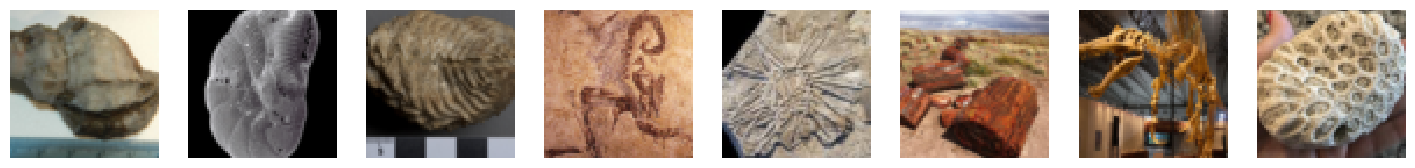

In [20]:
# Visualizing some sample images
figure = plt.figure(figsize=(18, 14))
cols, rows = 8, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), interpolation='none')
plt.show()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Here, we will define a model for a Variational Autoencoder. It is mostly similar to Autoencoders with a few differences. Instead of the encoder outputing a deterministic latent space representation like in autoencoders, the encoder will now output a mean and log variance vector. The latent space representation will then be sampled using them. We output log variance instead of just variance because the varaince always has to be postive.

The docoder is same as in autoencoders.

For sampling the latent space representation, we use a reparameterization trick so that it is possible to backpropagate. The basic idea is given below in the Fig 2.

!["Reparameteriztion Trick"](https://blog.bayeslabs.co/assets/img/vae_part_1_1.png)

<p align = "center">
Fig.2 - Reparameteriztion Trick
(<a href=https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae">
source
</a>)
</p>



In [7]:
class Reshape(nn.Module):
    """A custom reshape layer."""
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)


class VariationalAutoEncoder(nn.Module):
    """Variational Autoencoder model"""
    def __init__(self, z, nwh):
        super(VariationalAutoEncoder, self).__init__()
        self.z = z
        self.nwhlat = nwh // 8
        self.encoder_top = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Flatten(1,-1),
            nn.Linear(128 * self.nwhlat * self.nwhlat, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )

        self.mu_layer =  nn.Linear(512, z)
        self.logvar_layer =  nn.Linear(512, z)

        self.decoder = nn.Sequential(
            nn.Linear(z, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, 128 * self.nwhlat * self.nwhlat),
            nn.BatchNorm1d(128 * self.nwhlat * self.nwhlat),
            nn.LeakyReLU(),

            Reshape((-1,128,self.nwhlat,self.nwhlat)),

            nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder_top(x)
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # First we convert the log variance to standard deviation and then we sample through reparameterization
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std*eps

    def forward(self, x):
        mu, logvar = self.encode(x)
        x = self.reparameterize(mu, logvar)
        x = self.decoder(x)
        return x, mu, logvar


model = VariationalAutoEncoder(z=Z, nwh=64)
model.to(device)

VariationalAutoEncoder(
  (encoder_top): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (mu_layer): Linear(in_features=512, out_features=256, bias=True)
  (logvar_layer): Linear(

In [8]:
# model summary
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         LeakyReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          36,992
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         LeakyReLU-9            [-1, 128, 8, 8]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 512]       4,194,816
      BatchNorm1d-12                  [-1, 512]           1,024
        LeakyReLU-13                  [-1, 512]               0
           Linear-14                  [

The loss funtion of Variational Autoencoders is called Evidence Lower Bound (ELBO) as it bounds the likelihood of the data which we want to maximise and it consists of two terms.
$$ L = ReconstructionLoss + KLDivergence $$
Reconstruction Loss is simply a measure of the likelihood of the reconstructed data output at the decoder. Typically, it is the mean squared error between input and output.

KL Divergence here acts as a regulaizer term becuase it is constraint on the form of tour approximate posterior. Typically, it is assumed as standard normal distribution.

$$KL(N(\mu, \sigma), N(0, 1)) = -0.5 * (1 + \log \sigma^2 - \sigma^2 - \mu^2)$$

Complete derivation of the loss for VAEs can be studied [here](https://deepai.org/publication/tutorial-deriving-the-standard-variational-autoencoder-vae-loss-function)

Another thing we need to take care of is the weight of each term in the loss. If the weight of KL Divergence is too high, it will then take focus off reconstruction and we will get bad reconstruction and if it is too low, the approximate posterior distribution will become non-continous.

In [9]:
# Loss function for Variational Auto Encoder
def loss_fn(y_true, y_pred, mu, logvar):

    # The total loss will consist of two parts: Reconstruction loss and KL divergence

    # Reconstruction Loss is simply mean squared error of gt and prediction like in autoencoders.
    reconstruction_loss = nn.functional.mse_loss(y_pred, y_true)

    # The second part of loss is the KL Divergence between the approximate posterior q(z|x) and latent prior p(z) assuming them to be normal distributions.
    kld_loss =   torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

    loss = (1-KLD_WEIGHT)*reconstruction_loss + KLD_WEIGHT*kld_loss
    return loss

In [10]:
# Defining the optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
# Training loop
loss_history = []
for i in range(1,EPOCHS+1):
    running_loss = 0
    pbar = tqdm(train_dataloader)
    for b, data in enumerate(pbar):
        # Every data instance is an input + label pair. We don't need the label
        inputs, _ = data
        inputs = inputs.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs, mu, logvar = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(inputs, outputs, mu, logvar)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Update Progress
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"loss": loss.item(), "avloss": running_loss/(b+1)})
    loss_history.append(running_loss)

Epoch 177/300: : 100%|██████████| 32/32 [00:41<00:00,  1.29s/it, loss=0.0124, avloss=0.0115]


Epoch 300/300: : 100%|██████████| 32/32 [00:45<00:00,  1.41s/it, loss=0.0154, avloss=0.0102]  


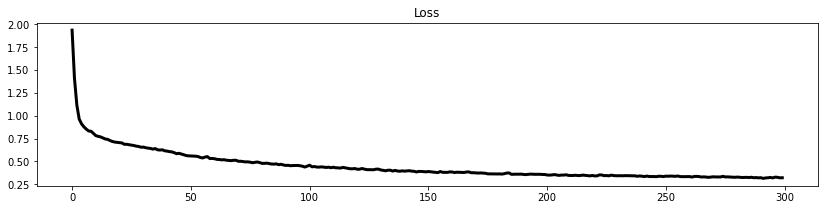

In [12]:
plt.figure(figsize=(14, 3))
plt.plot(loss_history, 'k', lw=3)
plt.title('Loss');

In [13]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.permute(1, 2, 0), interpolation='none')
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [14]:
# Set the model to eval state
model.eval()

VariationalAutoEncoder(
  (encoder_top): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (mu_layer): Linear(in_features=512, out_features=256, bias=True)
  (logvar_layer): Linear(

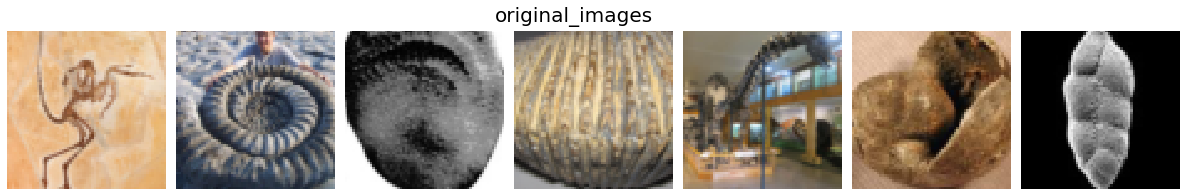

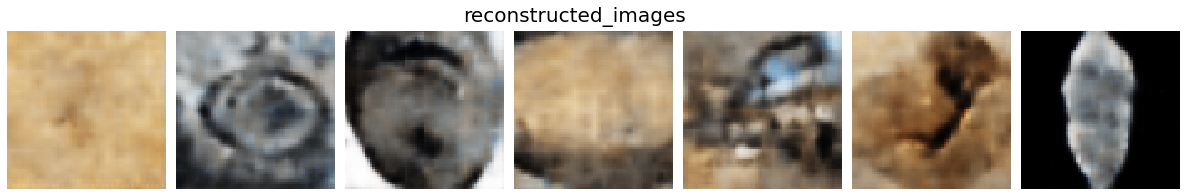

In [15]:
# Display some sample images and there reconstruction through auto encoders

images = []
cols, rows = 7, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols, "original_images")
with torch.no_grad():
    reconstructed_images = model(torch.stack(images).to(device))[0].cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")

### Generation through Variational AutoEncoders

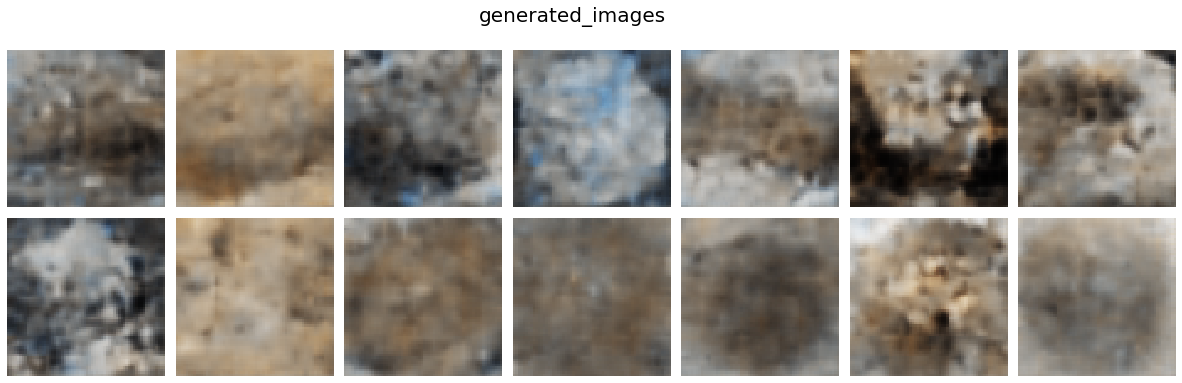

In [16]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder
rows, cols = 2, 7
sample_encodings = torch.randn(rows*cols, Z).to(device)
with torch.no_grad():
    generations = model.decoder(sample_encodings).cpu()
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")

### Discussion

With Variational AutoEncoders, we sacrificed a little in reconstruction but in the end we got some decent generations from completely random inputs. But as it can be seen, they are blurry. This is one of the shortcommings of VAEs, that they produce blurry images.